# Kurtosis Experiments

For our kurtosis experiments, we will test different integrands and use RQMC with $R$ independent replications and $n$ QMC points per replication. We will use the following RQMC Methods: LMS_DS, DS, and NUS for Sobol. The $n$ will be varied from $2^0$ to $2^{8}$ while $R$ will be kept constant at 1000. The goal is to see how the kurtosis changes as $n$ changes for the different RQMC methods listed above.

Kurtosis formula: 
$
\text{Kurt}(X) = \frac{\mathbb{E}\big[(X - \mu)^4\big]}{\sigma^4}
$

We use the following integrand with any dimension $d$:

$
Y = f(\mathbf{x}) =  -d + \sum_{j=1}^d x_j e^{x_j}
$ (referred to as "smooth_anyd" in our code)


We also use the following ridge functions:

1. $ g_{jmp}(w) = 1{\{w \geq 1\}} $
2. $ g_{knk}(w) = \frac {\min(\max(−2, w), 1) + 2} {3} $
3. $ g_{smo}(w) = \Phi (w)$
4. $ g_{fin}(w) = \min(1,\sqrt{\max(w + 2, 0)}/2) $

$w = \frac{1}{\sqrt{d}} \sum_{j=1}^{d}\Phi^{-1}(x_{j})$, $\Phi(.)$ is the CDF of standard Normal Distribution on R, denoted by $ \mathcal{N}(0,1)$, and $x \sim U(0, 1)^d$.

In [31]:
import qmcpy as qp
from scipy.stats import kurtosis,norm,mstats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Setting up the parameters to be used:

In [32]:
qmc_generators = {
    "Sobol": ["LMS_DS","DS", "NUS"]
} # The different QMC generators with different randomizations
num_randomizations = sum(len(rands) for rands in qmc_generators.values())
labels = []
for gen, rands in qmc_generators.items():
    for rand in rands:
        labels.append(f"{gen}_{rand}")
labels = np.array(labels)

R = 1000 # The number of independent replications
n_vary = 2**np.arange(0,9) # The different number of QMC points per replication

gs = {
    "jmp": lambda w: w>=1, 
    "knk": lambda w: ((np.minimum(np.maximum(-2,w),1)) + 2) / 3,
    "smo": lambda w: norm.cdf(w + 1),
    "fin": lambda w: np.minimum(1,((np.sqrt(np.maximum(w+2,0)))/2)),
    "smooth_anyd": lambda dim, w: -dim + np.sum(w * np.exp(w), axis=2)
} # The ridge functions and integrand with any dimension d

mean_arr = np.array([0.1587,0.6417, 0.76025,0.6773,0]) # The theoretical means of the functions being tested


d = np.array([1,2,4,8]) # The different d's to test on for ridge functions and integrand with any dimension d

# seed setting

global_seed = 7
parent_seed = np.random.SeedSequence(global_seed)

The function to generate IID replications of QMC samples

In [33]:
def gen_qmc_samples_iid(discrete_distrib, n = 2**8, function = None, ridge = False):
    x_rld = discrete_distrib.gen_samples(n).reshape((discrete_distrib.replications,n,discrete_distrib.d))
    if ridge is True:
        return x_rld
    if function is None:
        y_rld = x_rld[...,0]
    else:
        y_rld = function(x_rld)
    return y_rld.mean(1),y_rld.flatten()

Generating the QMC samples that will be used in both the ridge and integrands

In [34]:
x_qmc_arr = np.empty((len(labels), len(n_vary)), dtype=object)
counter = 0
for gen, rands in qmc_generators.items():
    for rand in rands:
        for i in range(len(n_vary)):
            child_seed = parent_seed.spawn(1)[0]
            if gen.lower() == "sobol":
                distrib = qp.Sobol(d[-1], randomize = rand, seed = child_seed, replications = R)
            elif gen.lower() == 'halton':
                distrib = qp.Halton(d[-1], randomize = rand, seed = child_seed, replications = R)
            else:
                distrib = qp.Lattice(d[-1], randomize = rand, seed = child_seed, replications = R)
            x_qmc_arr[counter,i] = gen_qmc_samples_iid(discrete_distrib=distrib,n = n_vary[i],ridge = True)
        counter = counter + 1

### Ridge Function and Integrand with any dimension $d$ Simulation

In [35]:
qmc_arr_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)),dtype=object)
kurr_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)))
var_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)))
mean_ridge = np.empty((len(labels),len(d),len(gs), len(n_vary)))
counter = 0
for gen, rands in qmc_generators.items():
    for rand in rands:
        for i in range(len(n_vary)):
            x_qmc = norm.ppf(x_qmc_arr[counter, i])
            for j in range (len(d)):
                w_qmc = x_qmc[:, :, :d[j]].sum(axis = 2)/np.sqrt(d[j])
                g_counter = 0
                for g in gs.values():
                    if g_counter == (len(gs) - 1):
                        x_qmc_int = x_qmc_arr[counter, i]
                        w_qmc = x_qmc_int[:,:,:d[j]]
                        qmc_arr_ridge[counter, j, g_counter,i] = g(d[j],w_qmc).mean(axis = 1)
                    else:
                        qmc_arr_ridge[counter, j, g_counter,i] = g(w_qmc).mean(axis = 1)
                    kurr_ridge[counter, j, g_counter, i] = kurtosis(qmc_arr_ridge[counter, j, g_counter,i], bias=False, fisher=False)
                    var_ridge[counter, j, g_counter, i] = np.var(qmc_arr_ridge[counter, j, g_counter,i], ddof=1)
                    mean_ridge[counter, j, g_counter, i] = np.mean(qmc_arr_ridge[counter, j, g_counter,i])
                    g_counter = g_counter + 1
        counter = counter + 1

Kurtosis, Variance, and Mean of R replications vs $n$ for Ridge Function and Integrand with any dimension $d$ Simulations

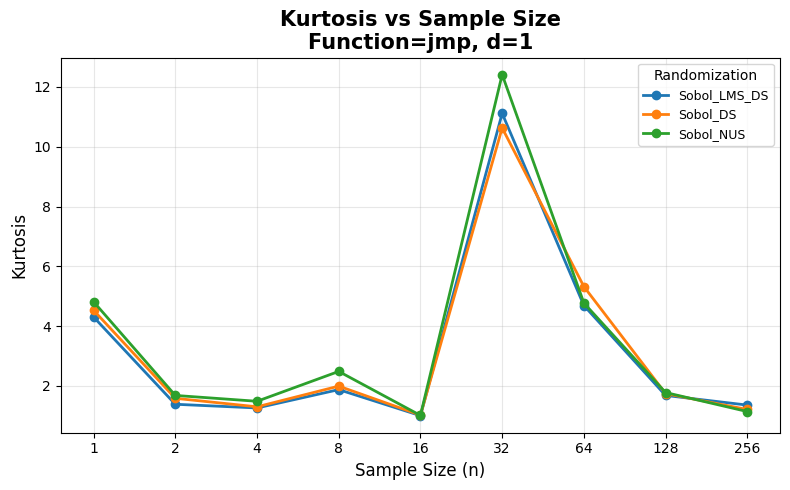

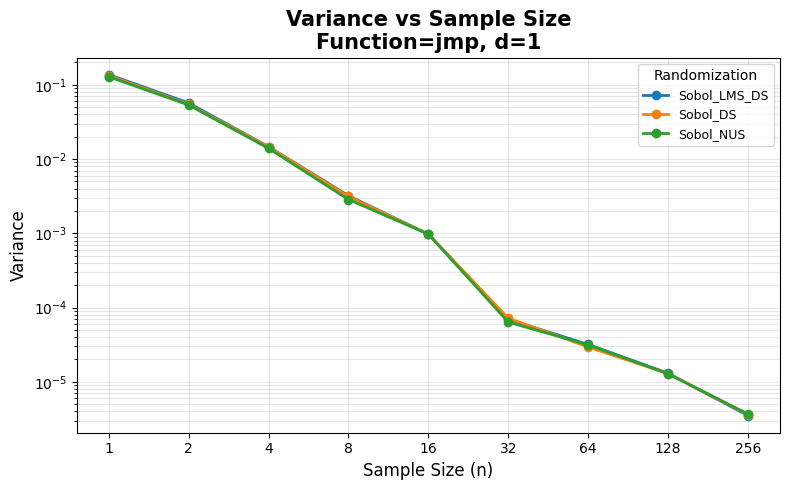

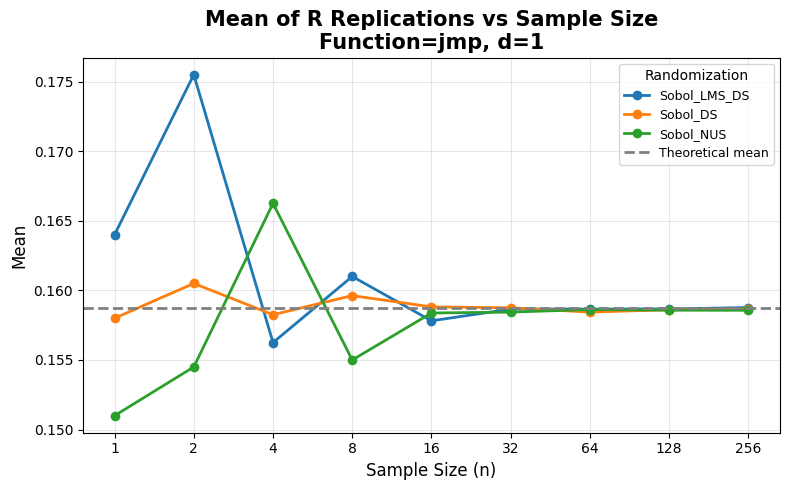

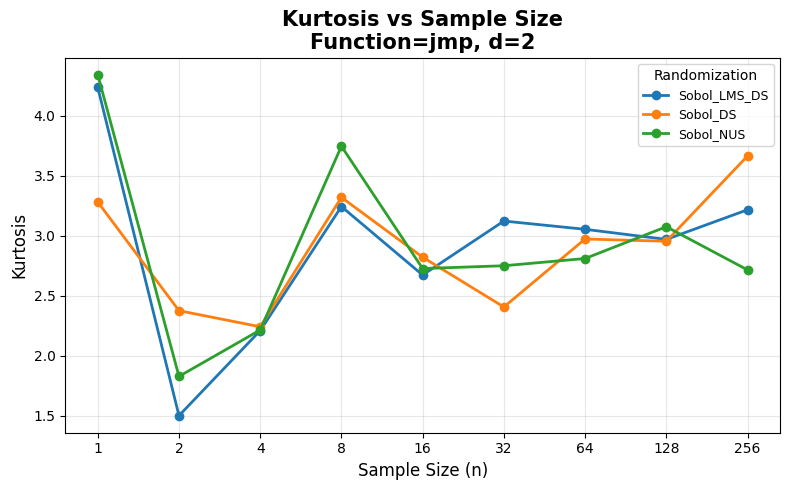

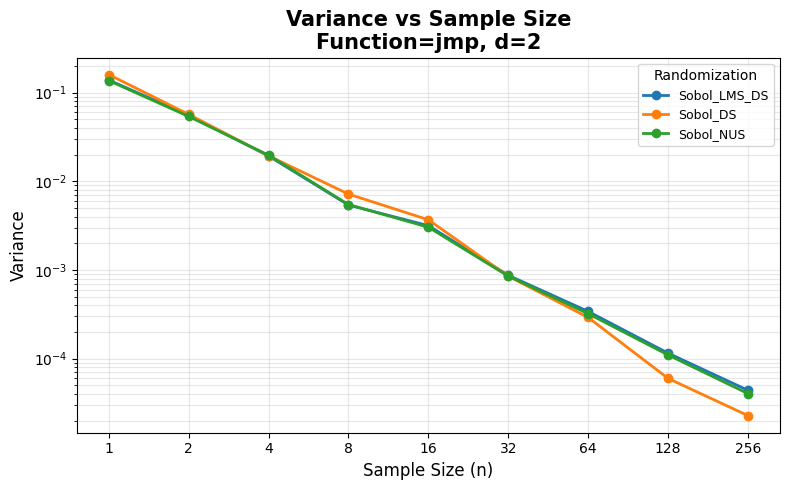

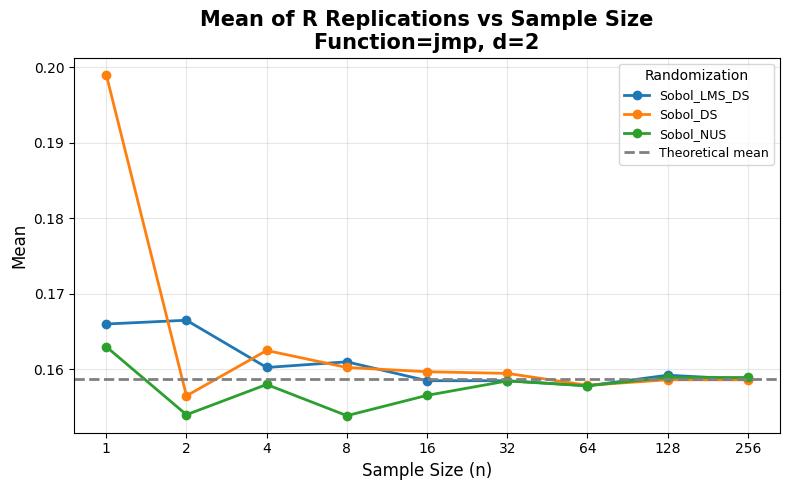

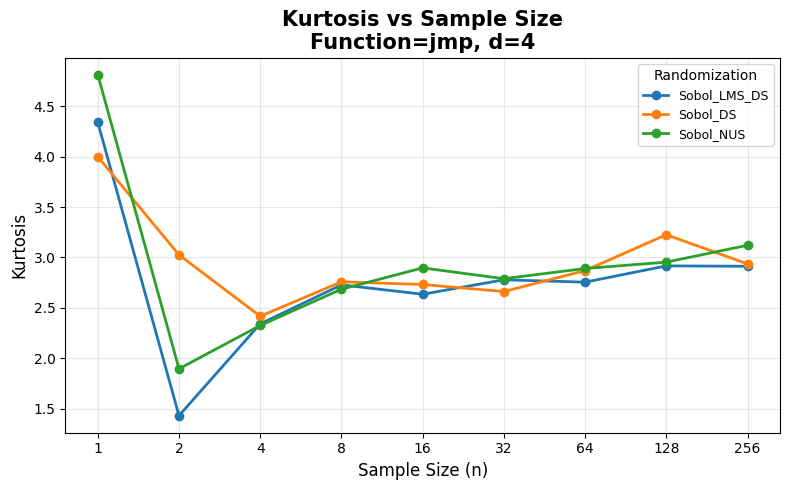

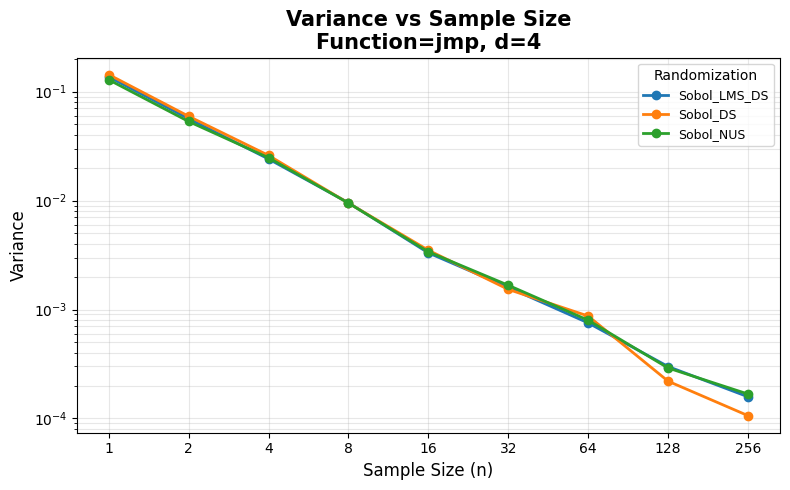

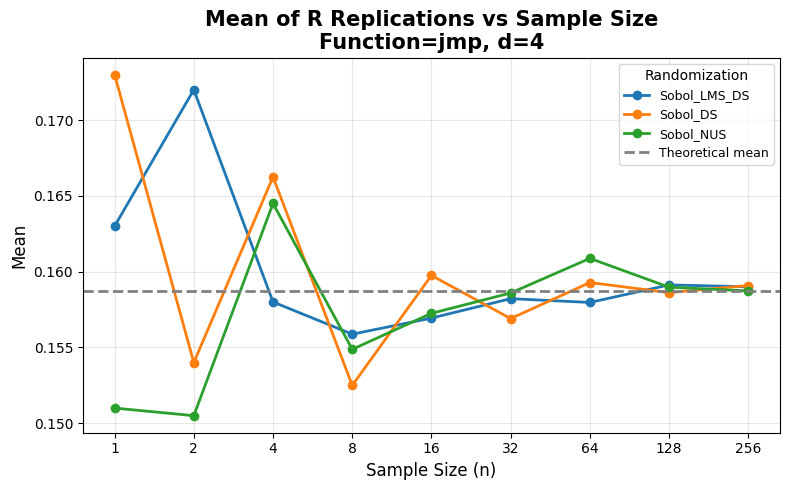

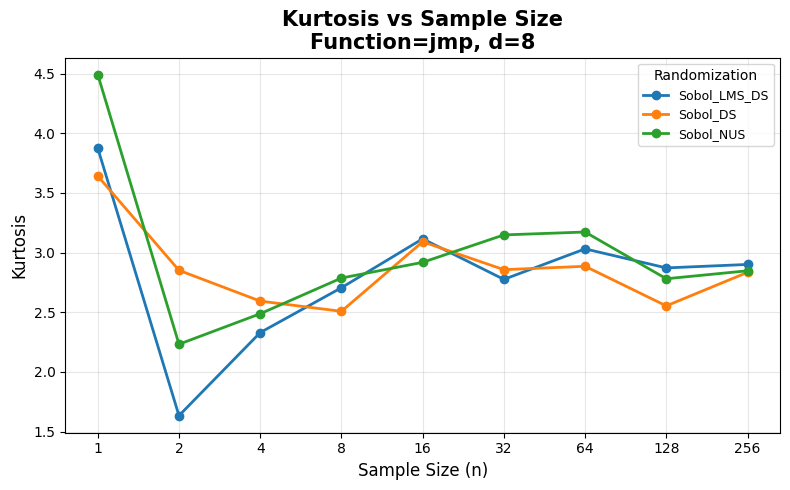

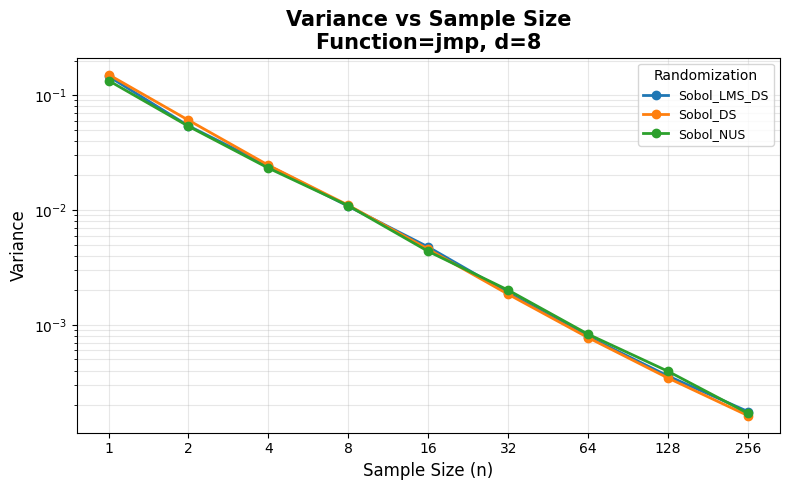

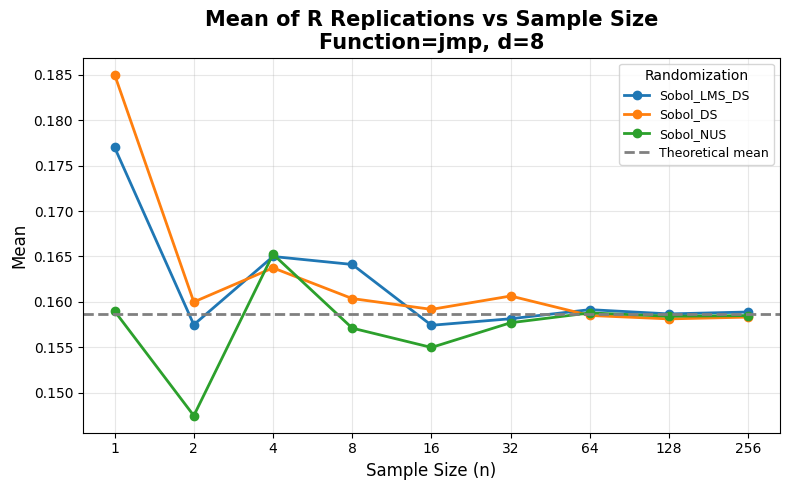

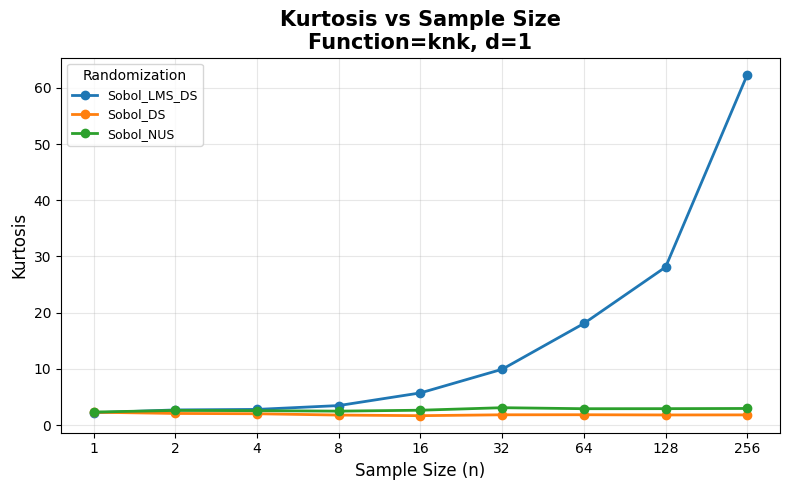

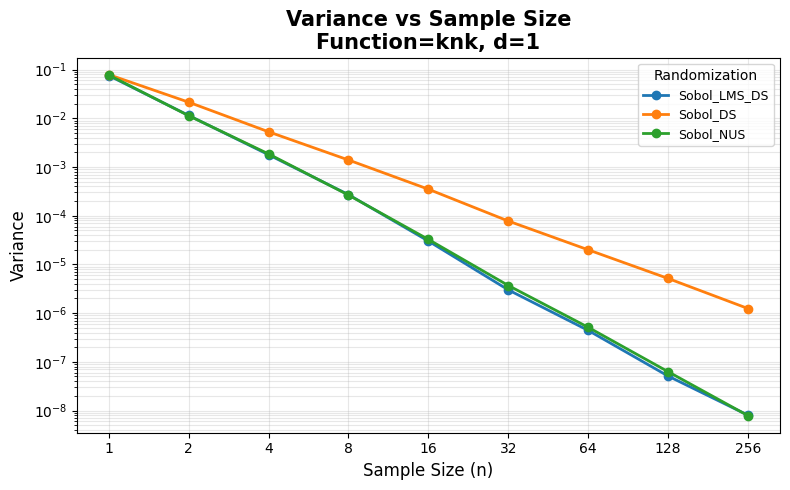

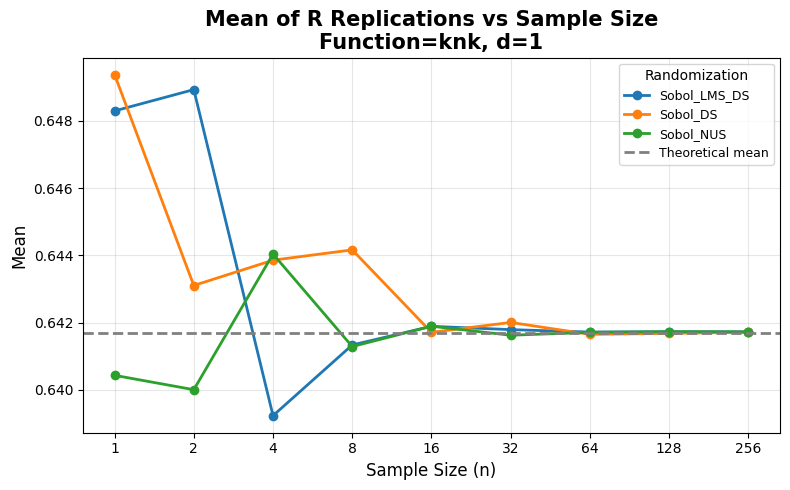

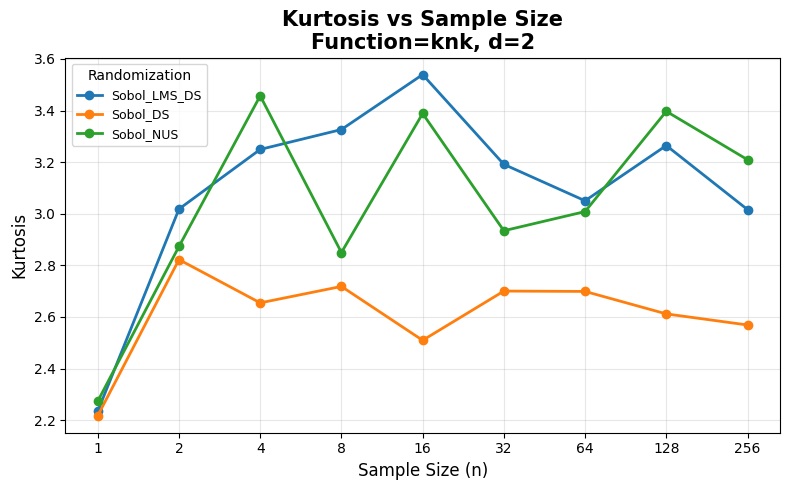

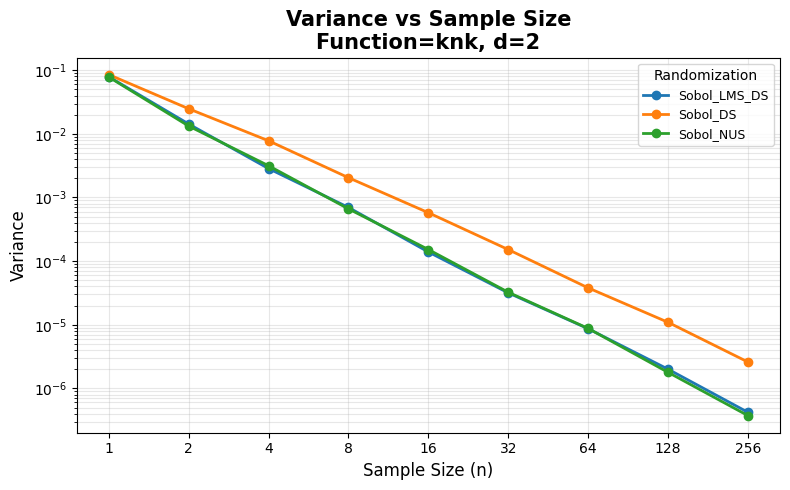

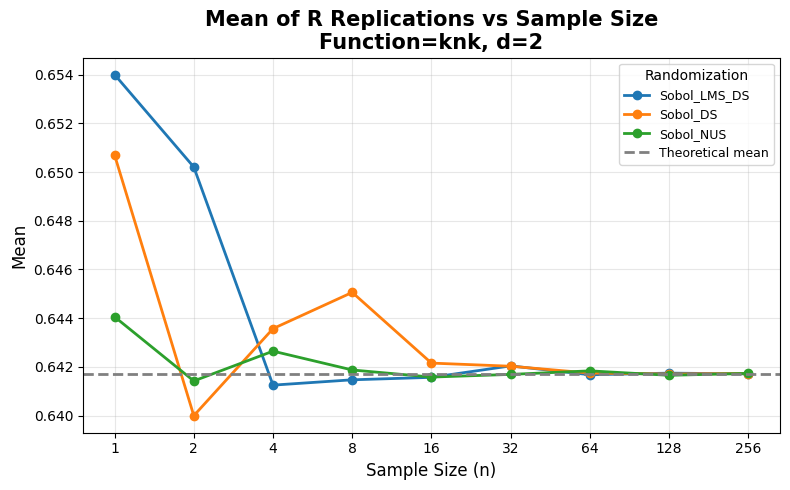

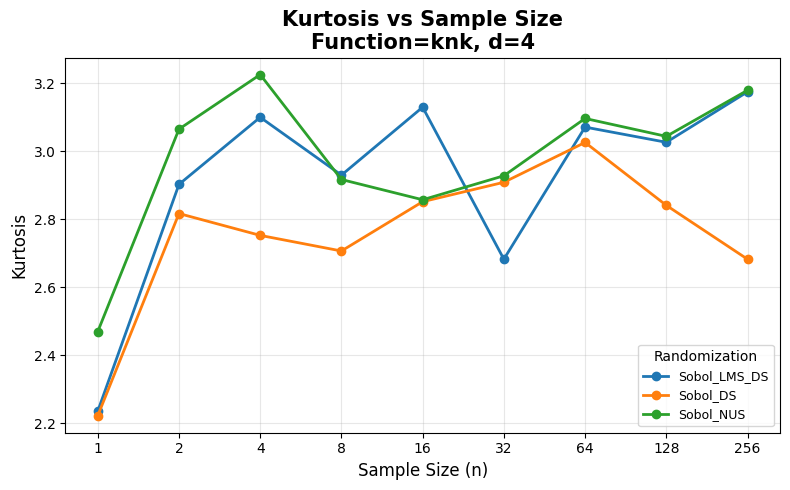

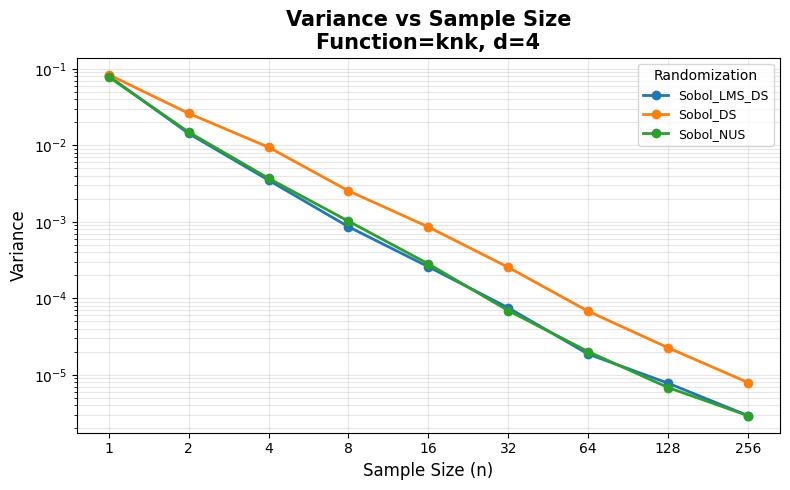

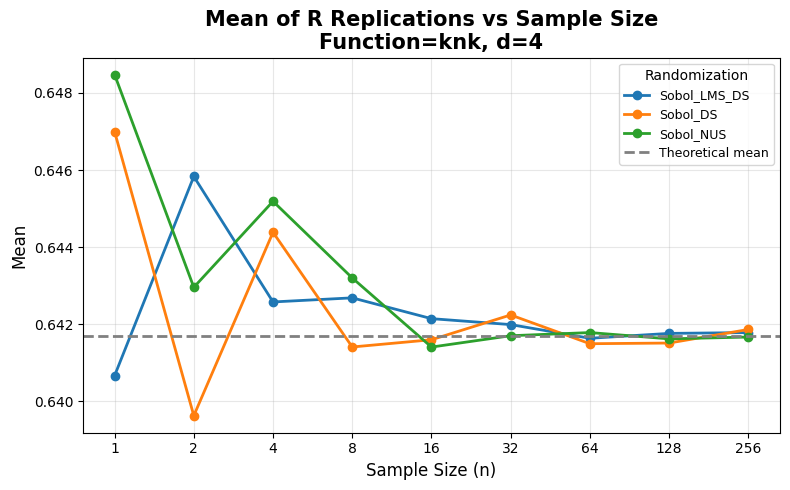

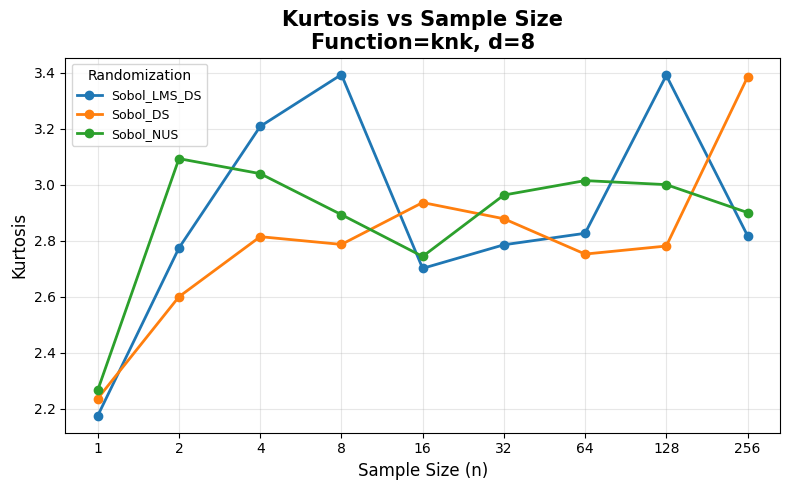

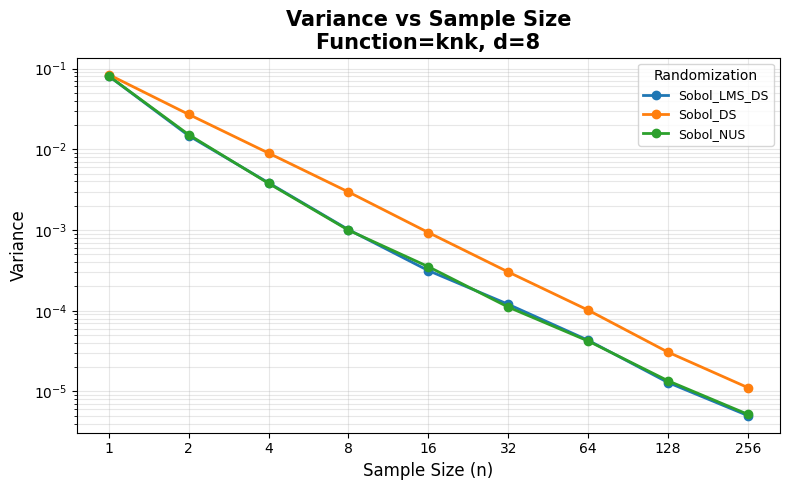

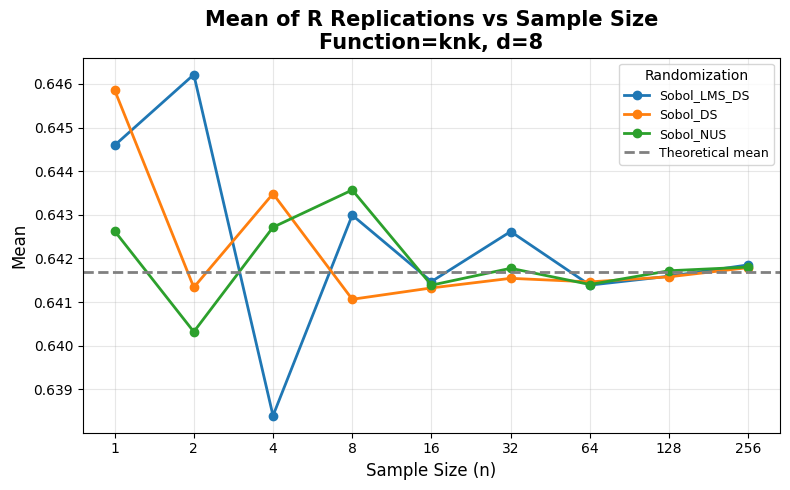

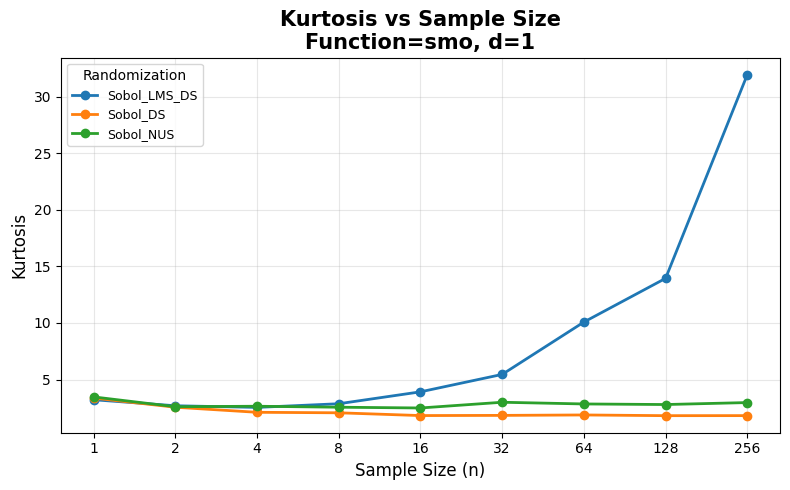

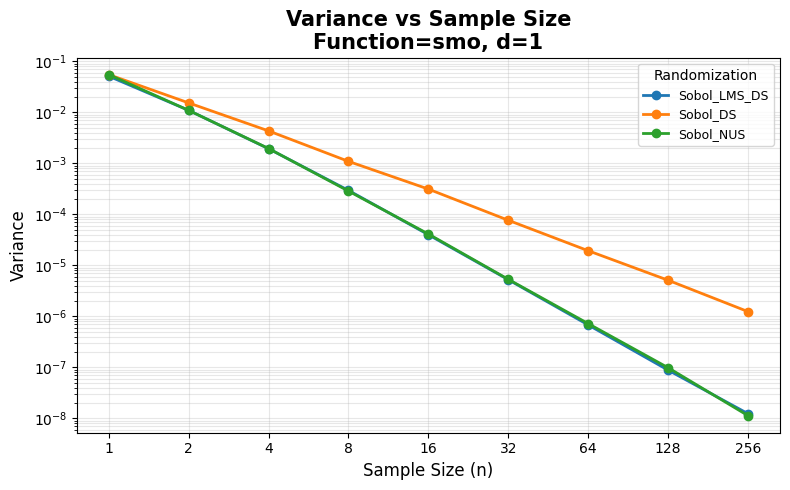

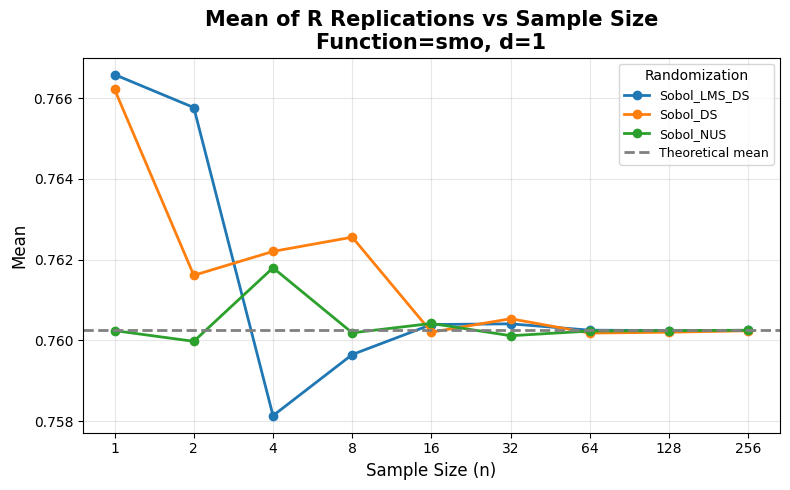

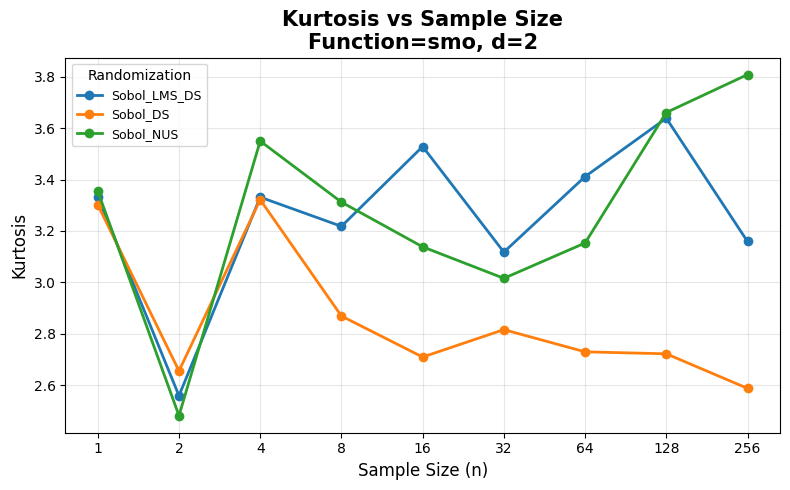

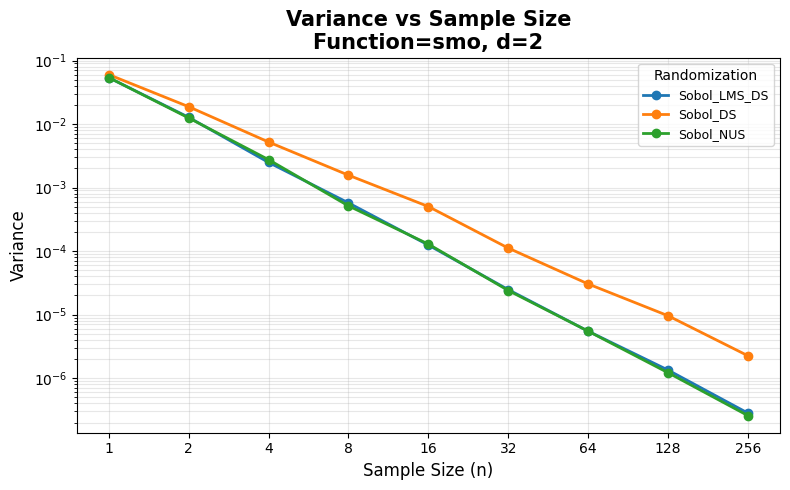

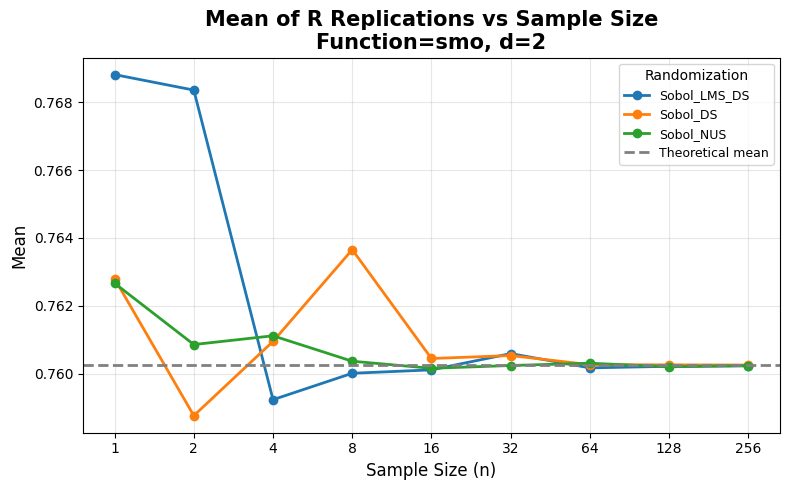

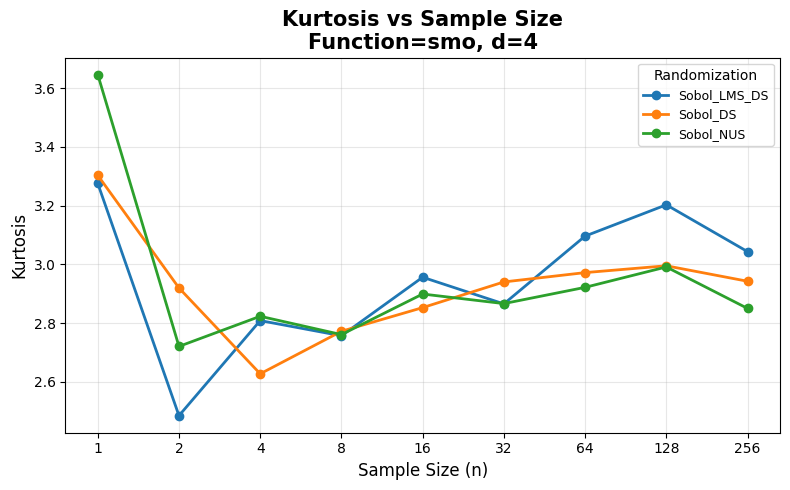

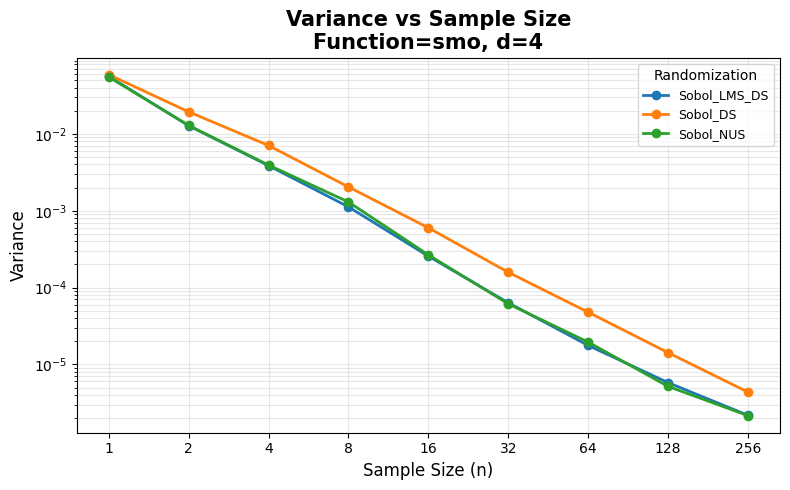

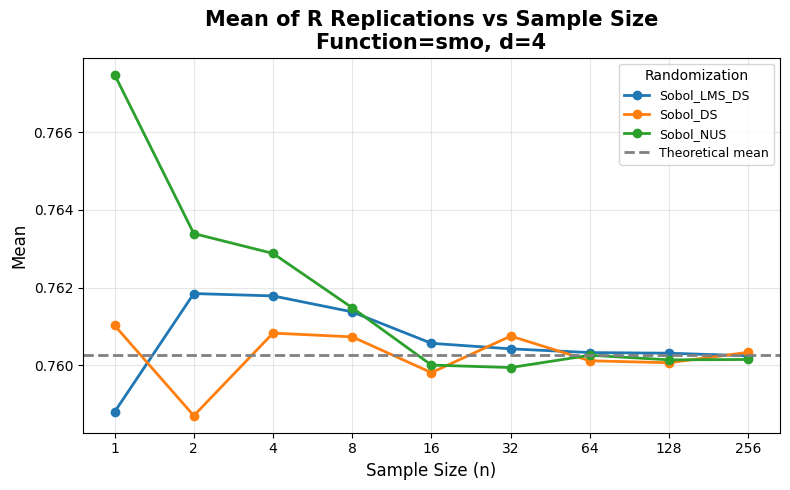

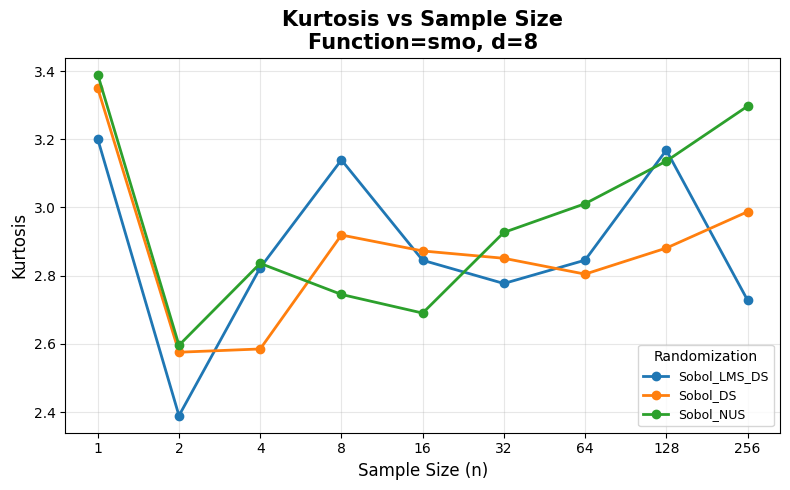

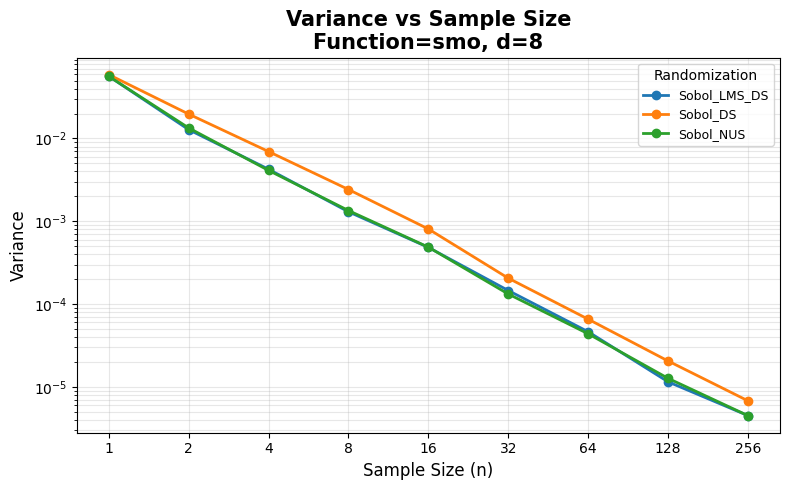

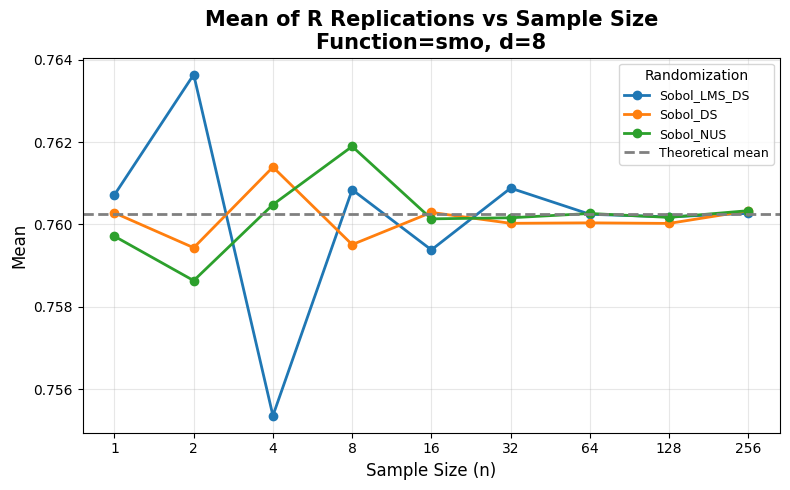

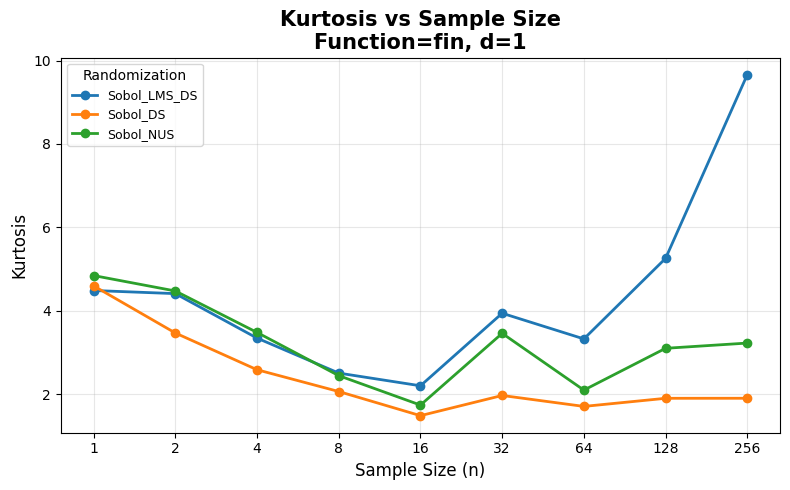

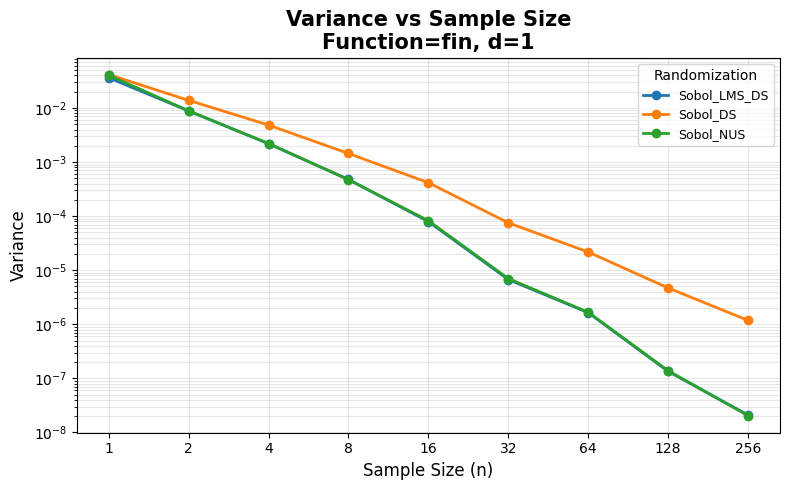

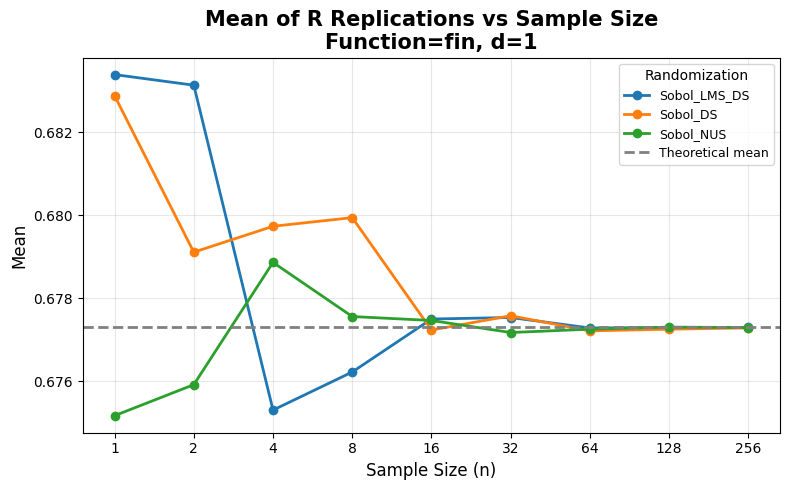

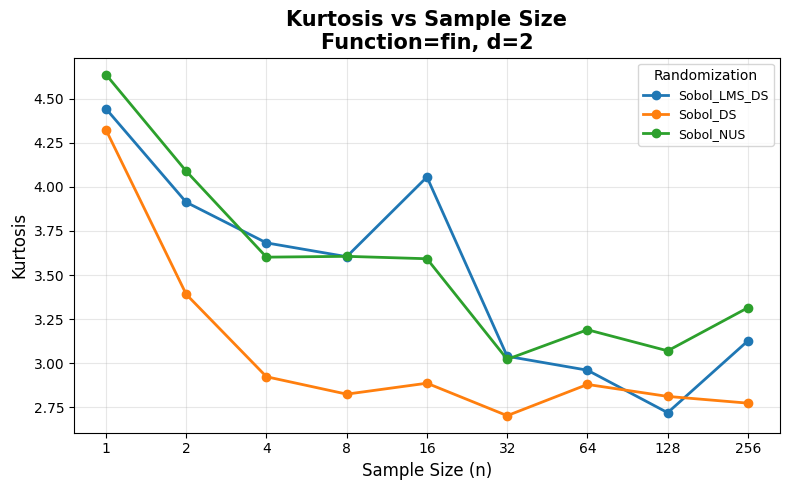

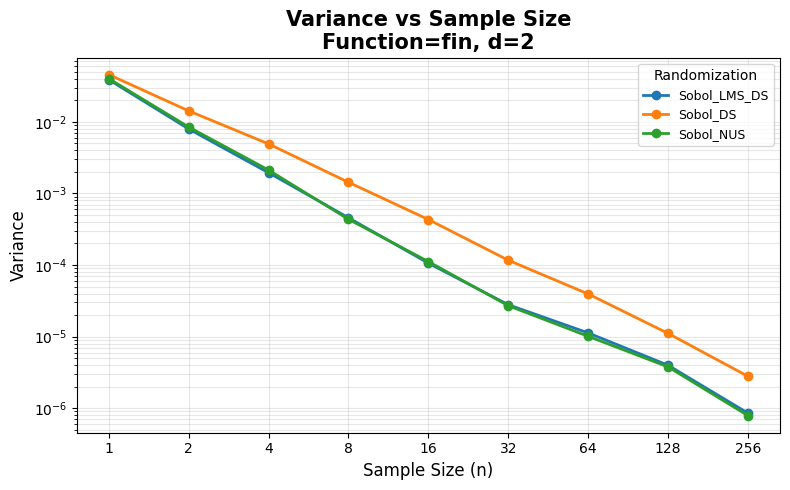

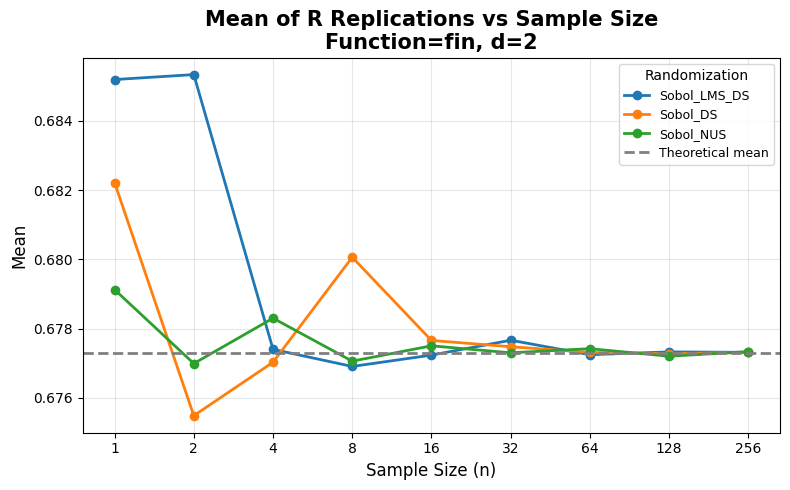

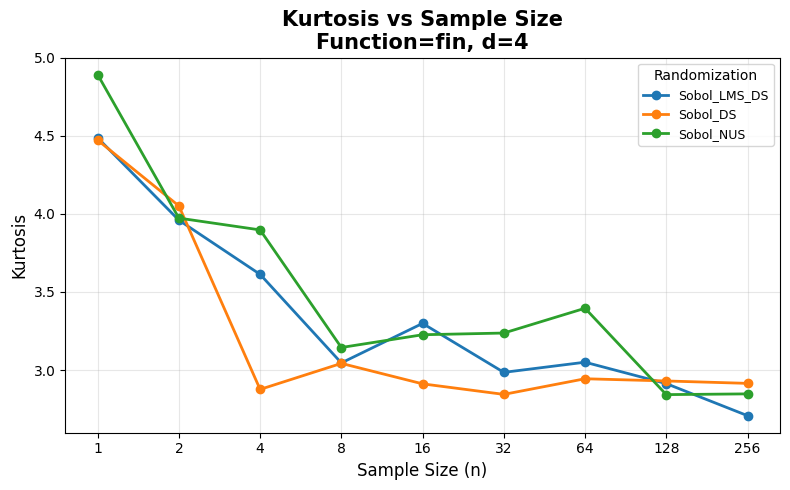

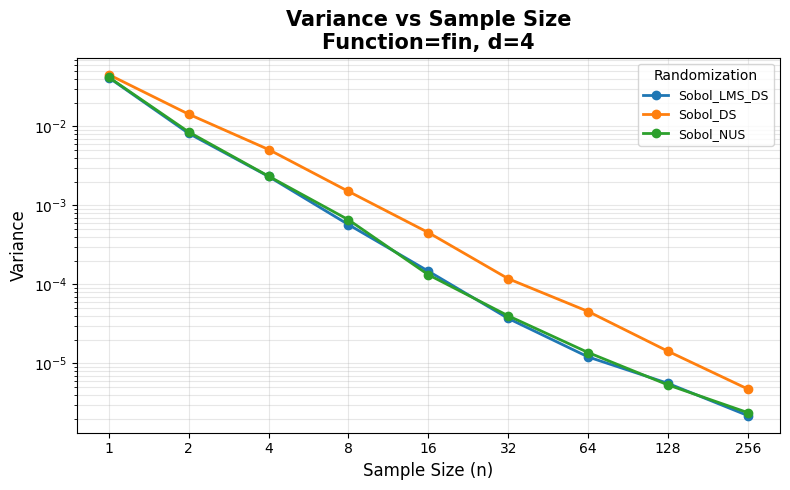

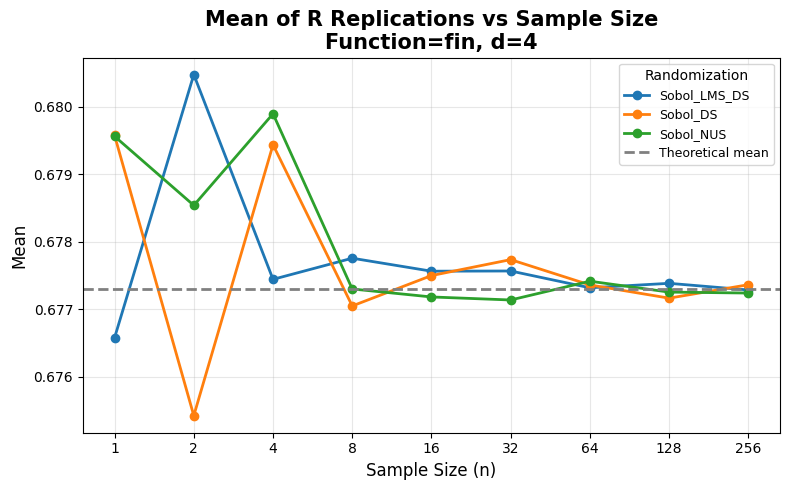

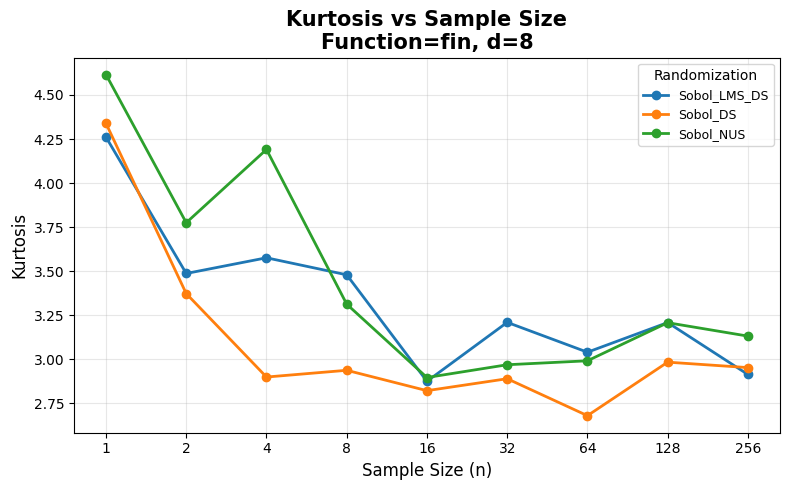

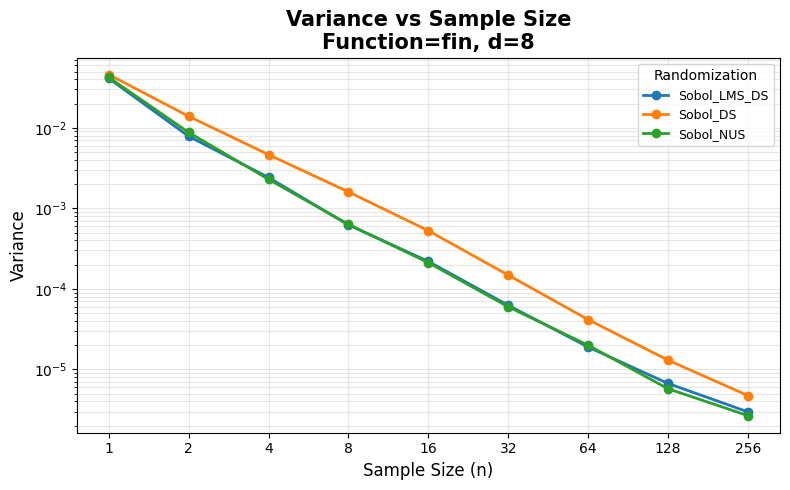

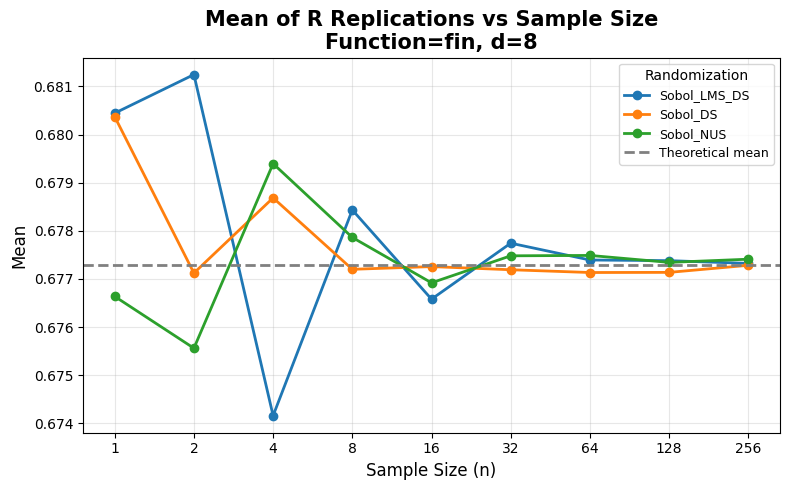

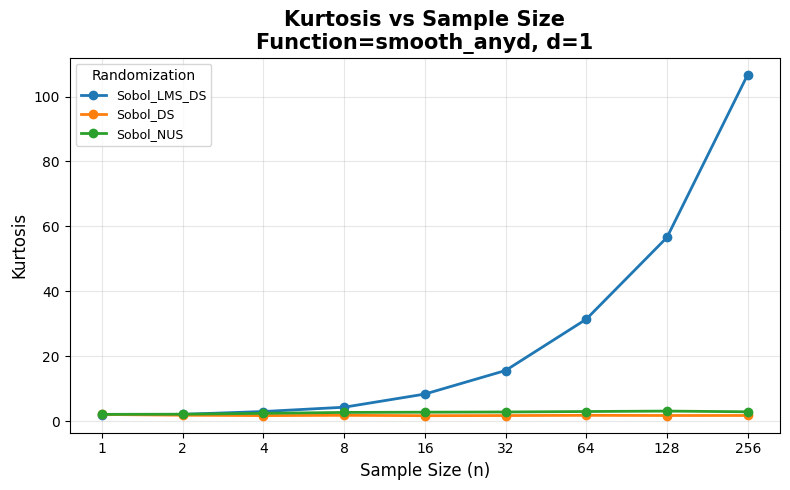

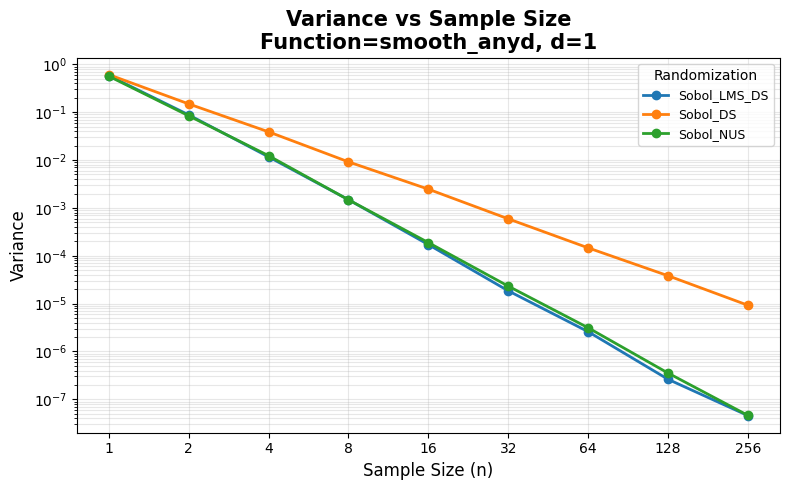

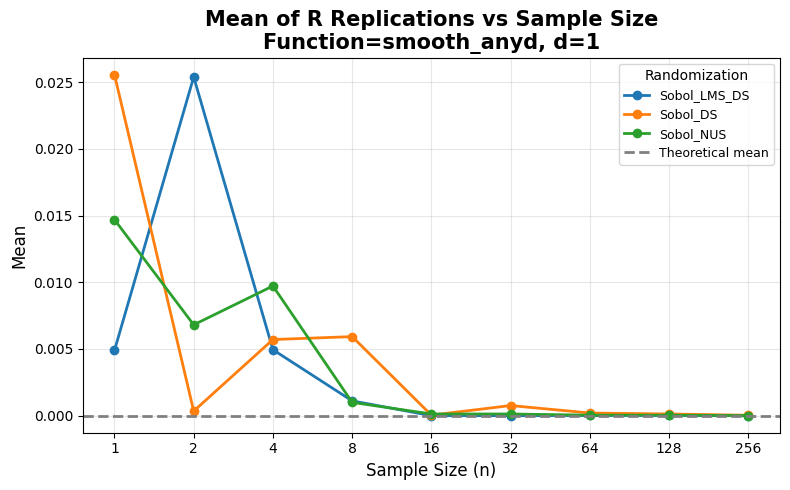

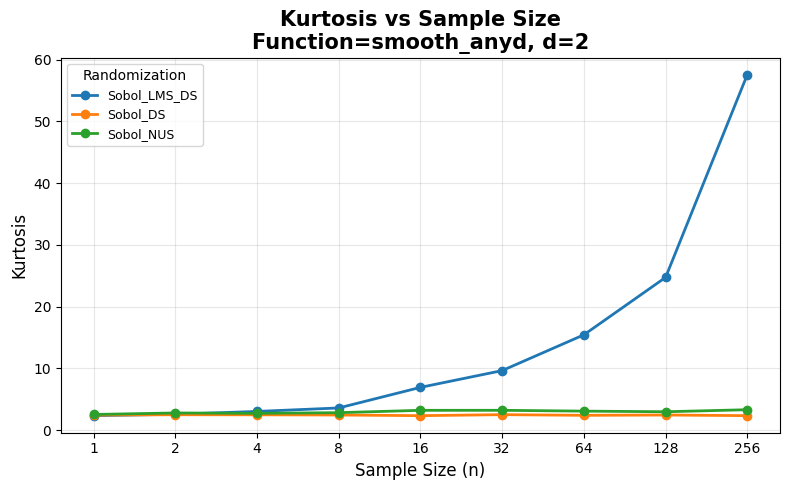

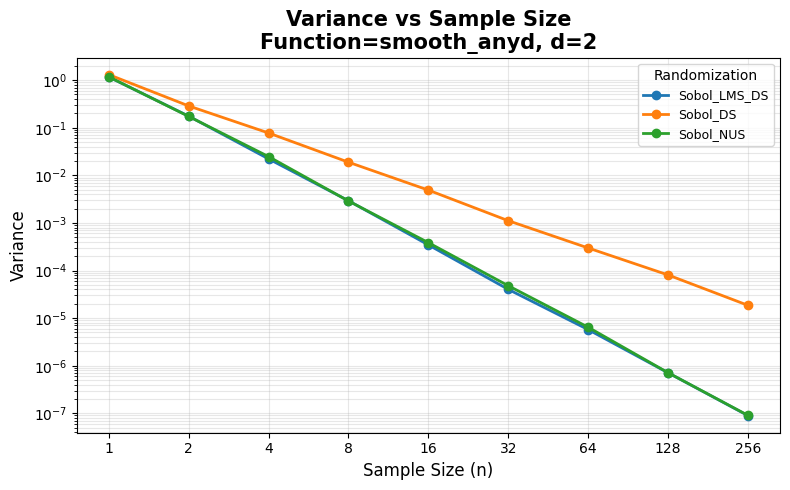

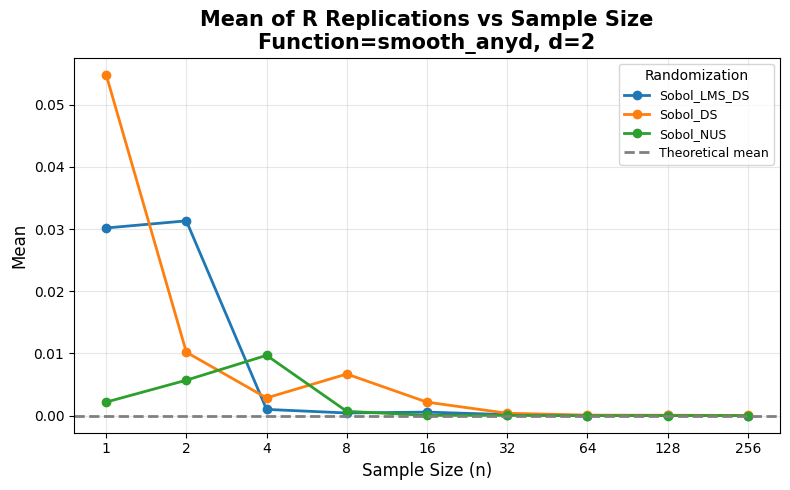

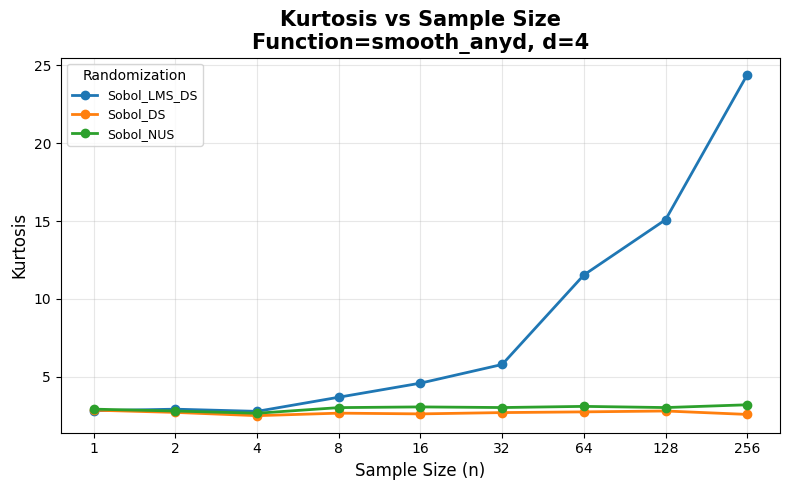

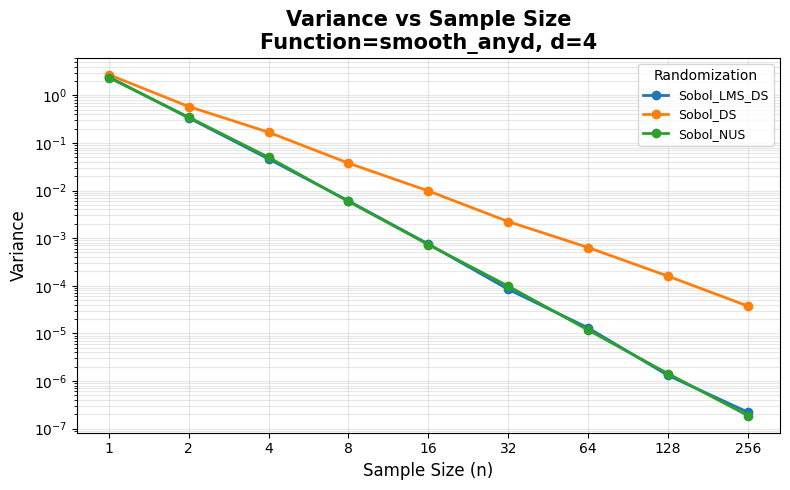

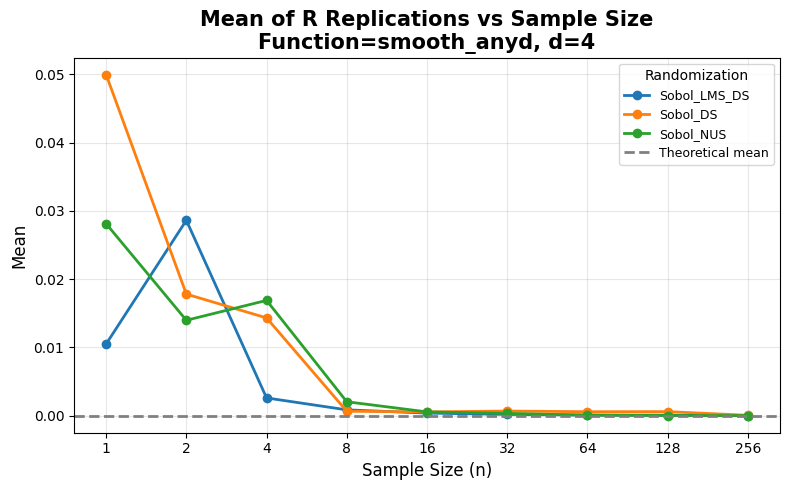

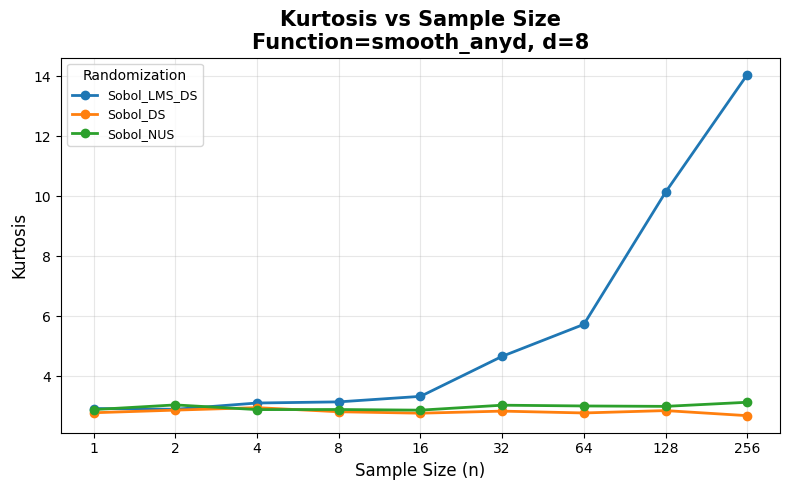

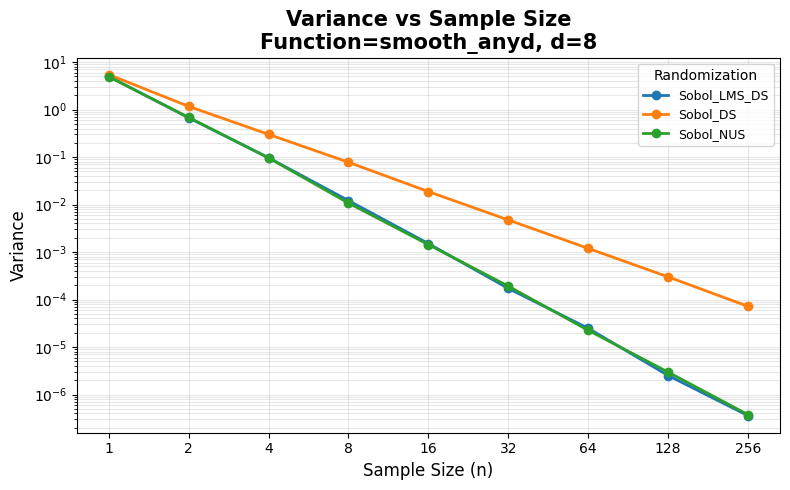

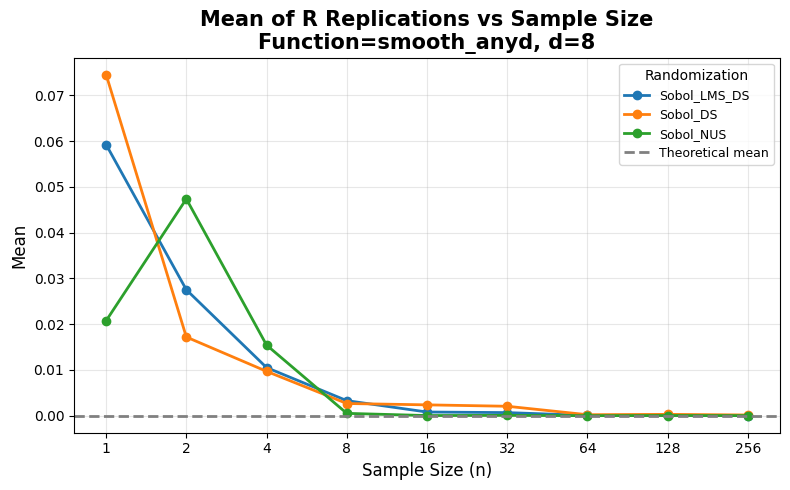

In [ ]:
for i_g, (gname, gfunc) in enumerate(gs.items()):
    for i_d, dd in enumerate(d):
        
        fig_kurt, ax_kurt = plt.subplots(figsize=(8, 5))
        for i_l, label in enumerate(labels):
            ax_kurt.plot(
                n_vary,
                kurr_ridge[i_l, i_d, i_g, :],
                marker='o',
                linewidth=2,
                markersize=6,
                label=label
            )
        
        ax_kurt.set_xscale('log', base=2)
        ax_kurt.set_xticks(n_vary)
        ax_kurt.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax_kurt.set_xlabel("Sample Size (n)", fontsize=12)
        ax_kurt.set_ylabel("Kurtosis", fontsize=12)
        ax_kurt.set_title(f"Kurtosis vs Sample Size\nFunction={gname}, d={dd}",
                          fontsize=15, weight='bold')
        ax_kurt.grid(True, which="both", alpha=0.3)
        ax_kurt.tick_params(axis="both", labelsize=10)
        ax_kurt.legend(title="Randomization", fontsize=9, title_fontsize=10, loc="best")
        
        fig_kurt.tight_layout()
        plt.show()

        fig_var, ax_var = plt.subplots(figsize=(8, 5))
        for i_l, label in enumerate(labels):
            ax_var.plot(
                n_vary,
                var_ridge[i_l, i_d, i_g, :],
                marker='o',
                linewidth=2,
                markersize=6,
                label=label
            )

        ax_var.set_xscale('log', base=2)
        ax_var.set_yscale('log')
        ax_var.set_xticks(n_vary)
        ax_var.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax_var.set_xlabel("Sample Size (n)", fontsize=12)
        ax_var.set_ylabel("Variance", fontsize=12)
        ax_var.set_title(f"Variance vs Sample Size\nFunction={gname}, d={dd}",
                         fontsize=15, weight='bold')
        ax_var.grid(True, which="both", alpha=0.3)
        ax_var.tick_params(axis="both", labelsize=10)
        ax_var.legend(title="Randomization", fontsize=9, title_fontsize=10, loc="best")
        
        fig_var.tight_layout()
        plt.show()

        fig_mean, ax_mean = plt.subplots(figsize=(8, 5))
        for i_l, label in enumerate(labels):
            ax_mean.plot(
                n_vary,
                np.abs(mean_ridge[i_l, i_d, i_g, :]),  
                marker='o',
                linewidth=2,
                markersize=6,
                label=f"{label}"
            )
        
        theoretical_mean = np.abs(mean_arr[i_g])
        ax_mean.axhline(
            theoretical_mean,
            color='gray',
            linestyle='--',
            linewidth=2,
            label='Theoretical mean'
        )

        ax_mean.set_xscale('log', base=2)
        ax_mean.set_xticks(n_vary)
        ax_mean.get_xaxis().set_major_formatter(plt.ScalarFormatter())
        ax_mean.set_xlabel("Sample Size (n)", fontsize=12)
        ax_mean.set_ylabel("Mean", fontsize=12)
        ax_mean.set_title(f"Mean of R Replications vs Sample Size\nFunction={gname}, d={dd}",
                          fontsize=15, weight='bold')
        ax_mean.grid(True, which="both", alpha=0.3)
        ax_mean.tick_params(axis="both", labelsize=10)
        ax_mean.legend(title="Randomization", fontsize=9, title_fontsize=10, loc="best")

        fig_mean.tight_layout()
        plt.show()




### Identifying cases where kurtosis goes quite high for the largest $n$

Cases with kurtosis going quite high for largest $n$ are: 
* knk (d = 1) LMS_DS - Sobol
* smo (d = 1) LMS_DS - Sobol
* fin (d = 1) LMS_DS - Sobol
* smooth_anyd (d = 1,2,4,8) LMS_DS - Sobol


Some trends could be:
* The only randomization for Sobol for which kurtosis seems to quite high for the largest $n$ is LMS_DS
* If the function is jumpy, it doesn't seem the kurtosis goes quite high for the largest $n$ for LMS_DS for any dimension $d$
* Predominantly, the kurtosis going quite high for the largest $n$ for LMS_DS with $d = 1$, except smooth_anyd which exhibits it in all dimensions tested but the value of kurtosis seems to be going down with dimension increase. So maybe high dimensions/increase in dimension doesn't exhibit high kurtosis with largest $n$ for LMS_DS.

### Using Winsorize for cases where kurtosis goes quite high for largest $n$

We will use winsorize (5% on each side) for cases where kurtosis goes quite high for the largest $n$ and see how that makes a difference on the kurotis value. We will only apply this to the largest $n$ tested.

In [37]:
knk_d1 = mstats.winsorize(qmc_arr_ridge[0, 0, 1, len(n_vary) - 1],limits = [0.05,0.05])
kur_knk_d1 = kurtosis(knk_d1,bias = False, fisher=False)
print(f"Orignal Kurtosis for knk d = 1 LMS_DS at n = 2^8: {kurr_ridge[0, 0, 1, len(n_vary) - 1]}")
print(f"Kurtosis for knk d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: {kur_knk_d1}")
print()

smo_d1 = mstats.winsorize(qmc_arr_ridge[0, 0, 2, len(n_vary) - 1],limits = [0.05,0.05])
kur_smo_d1 = kurtosis(smo_d1,bias = False, fisher=False)
print(f"Orignal Kurtosis for smo d = 1 LMS_DS at n = 2^8: {kurr_ridge[0, 0, 2, len(n_vary) - 1]}")
print(f"Kurtosis for smo d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: {kur_smo_d1}")
print()

fin_d1 = mstats.winsorize(qmc_arr_ridge[0, 0, 3, len(n_vary) - 1],limits = [0.05,0.05])
kur_fin_d1 = kurtosis(fin_d1,bias = False, fisher=False)
print(f"Orignal Kurtosis for fin d = 1 LMS_DS at n = 2^8: {kurr_ridge[0, 0, 3, len(n_vary) - 1]}")
print(f"Kurtosis for fin d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: {kur_fin_d1}")
print()

smooth_any_d_d1 = mstats.winsorize(qmc_arr_ridge[0, 0, 4, len(n_vary) - 1],limits = [0.05,0.05])
kur_smooth_any_d_d1 = kurtosis(smooth_any_d_d1,bias = False, fisher=False)
print(f"Orignal Kurtosis for smooth_any_d d = 1 LMS_DS at n = 2^8: {kurr_ridge[0, 0, 4, len(n_vary) - 1]}")
print(f"Kurtosis for smooth_any_d d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: {kur_smooth_any_d_d1}")
print()

smooth_any_d_d2 = mstats.winsorize(qmc_arr_ridge[0, 1, 4, len(n_vary) - 1],limits = [0.05,0.05])
kur_smooth_any_d_d2 = kurtosis(smooth_any_d_d2,bias = False, fisher=False)
print(f"Orignal Kurtosis for smooth_any_d d = 2 LMS_DS at n = 2^8: {kurr_ridge[0, 1, 4, len(n_vary) - 1]}")
print(f"Kurtosis for smooth_any_d d = 2 LMS_DS at n = 2^8 after doing winsorize 5% on each side: {kur_smooth_any_d_d2}")
print()

smooth_any_d_d4 = mstats.winsorize(qmc_arr_ridge[0, 2, 4, len(n_vary) - 1],limits = [0.05,0.05])
kur_smooth_any_d_d4 = kurtosis(smooth_any_d_d4,bias = False, fisher=False)
print(f"Orignal Kurtosis for smooth_any_d d = 4 LMS_DS at n = 2^8: {kurr_ridge[0, 2, 4, len(n_vary) - 1]}")
print(f"Kurtosis for smooth_any_d d = 4 LMS_DS at n = 2^8 after doing winsorize 5% on each side: {kur_smooth_any_d_d4}")
print()

smooth_any_d_d8 = mstats.winsorize(qmc_arr_ridge[0, 3, 4, len(n_vary) - 1],limits = [0.05,0.05])
kur_smooth_any_d_d8 = kurtosis(smooth_any_d_d8,bias = False, fisher=False)
print(f"Orignal Kurtosis for smooth_any_d d = 8 LMS_DS at n = 2^8: {kurr_ridge[0, 3, 4, len(n_vary) - 1]}")
print(f"Kurtosis for smooth_any_d d = 8 LMS_DS at n = 2^8 after doing winsorize 5% on each side: {kur_smooth_any_d_d8}")
print()

Orignal Kurtosis for knk d = 1 LMS_DS at n = 2^8: 62.351310863534124
Kurtosis for knk d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: 2.6124540210897895

Orignal Kurtosis for smo d = 1 LMS_DS at n = 2^8: 31.937478233686743
Kurtosis for smo d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: 3.019207944177831

Orignal Kurtosis for fin d = 1 LMS_DS at n = 2^8: 9.6645778993798
Kurtosis for fin d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: 2.36144935007864

Orignal Kurtosis for smooth_any_d d = 1 LMS_DS at n = 2^8: 106.75162178332398
Kurtosis for smooth_any_d d = 1 LMS_DS at n = 2^8 after doing winsorize 5% on each side: 6.530038756821934

Orignal Kurtosis for smooth_any_d d = 2 LMS_DS at n = 2^8: 57.565521538974814
Kurtosis for smooth_any_d d = 2 LMS_DS at n = 2^8 after doing winsorize 5% on each side: 6.80880691529611

Orignal Kurtosis for smooth_any_d d = 4 LMS_DS at n = 2^8: 24.39896930619292
Kurtosis for smooth_any_d d = 4 LMS_DS at n = 2^8 a